In [28]:
from __future__ import annotations

import math
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import importlib

import template, utility
[importlib.reload(lib) for lib in (template, utility)]

from template import Agent, Environment, EnvAnalyst
from utility import softmax

In [29]:
from numpy import ndarray


class MultArmedBandit(Environment):

    def __init__(self, k, max_steps, av_mean, av_var, reward_var, rng_seed=None) -> None:  # av - Action Value
        """If rng_seed is None, each time reset will init with random seed.
        Else reset will use same exact seed."""
        self.k, self.max_steps = k, max_steps
        self.av_mean, self.av_var = av_mean, av_var
        self.reward_var = reward_var

        self.seed = rng_seed

        self.current_step = 0

        self.terminated = True
    
    def reset(self) -> tuple[ndarray, dict]:
        self.terminated = False

        self.rng = np.random.RandomState(self.seed)

        self.action_values = self.rng.normal(self.av_mean, self.av_var, size=self.k)

        return np.ndarray(0), {}
    
    @property
    def action_space(self) -> set:
        return set(range(self.k))
    
    def step(self, action) -> tuple[ndarray, float, bool, bool, dict]:
        if self.terminated: raise Exception('Env already Terminated')

        reward = self.rng.normal(self.action_values[action], self.reward_var)

        if self.current_step >= self.max_steps:
            self.terminated = True
        self.current_step += 1

        return np.ndarray(), reward, self.terminated, False, {}


In [30]:
from numpy import ndarray


class MultArmedBandit(Environment):

    def __init__(self, k, max_steps, av_mean, av_var, reward_var, rng_seed=None) -> None:  # av - Action Value
        """If rng_seed is None, each time reset will init with random seed.
        Else reset will use same exact seed."""
        self.k, self.max_steps = k, max_steps
        self.av_mean, self.av_var = av_mean, av_var
        self.reward_var = reward_var

        self.rng_seed = rng_seed
    
    def reset(self) -> tuple[ndarray, dict]:
        self.terminated = False
        self.current_step = 0

        self.rng = np.random.RandomState(self.rng_seed)

        self.action_values = self.rng.normal(self.av_mean, self.av_var, size=self.k)

        return np.ndarray(0), {}
    
    @property
    def action_space(self) -> set:
        return set(range(self.k))
    
    def step(self, action) -> tuple[ndarray, float, bool, bool, dict]:
        if self.terminated: raise Exception('Env already Terminated')

        reward = self.rng.normal(self.action_values[action], self.reward_var)

        if self.current_step >= self.max_steps:
            self.terminated = True
        self.current_step += 1

        return np.ndarray(0), reward, self.terminated, False, {}


In [31]:
class RandomAgent(Agent):

    def __init__(self, rng_seed=None) -> None:
        """If rng_seed is None, each time reset will init with random seed.
        Else reset will use same exact seed."""
        self.rng_seed = rng_seed
        super().__init__()

    def reset(self):
        self.rng = random.SystemRandom(self.rng_seed)

    def choose_action(self, action_space):
        return self.rng.choice(list(action_space))
    

class GreedyAgent(Agent):

    def __init__(self, Q_init_value) -> None:
        self.Q_init_value = Q_init_value

    def reset(self):
        self.Q = None
        self.last_action = None
        self.n = None

    def choose_action(self, action_space):
        if self.Q is None:
            self.Q = np.full(shape=len(action_space), fill_value=self.Q_init_value, dtype=np.float64)
            self.n = np.zeros_like(self.Q)

        self.last_action = np.argmax(self.Q)
        
        self.n[self.last_action] += 1

        return self.last_action
    
    def action_feedback(self, observation, reward, terminated, truncated):
        self.Q[self.last_action] += (reward - self.Q[self.last_action]) / self.n[self.last_action]


class EpsilonGreedyAgent(GreedyAgent):

    def __init__(self, epsilon, Q_init_value, rng_seed=None) -> None:
        """If rng_seed is None, each time reset will init with random seed.
        Else reset will use same exact seed."""
        self.epsilon = epsilon
        self.rng_seed = rng_seed

        super().__init__(Q_init_value)

    def reset(self):
        self.rng = random.SystemRandom(self.rng_seed)

        super().reset()

    def choose_action(self, action_space):
        if self.Q is None:
            self.Q = np.full(shape=len(action_space), fill_value=self.Q_init_value, dtype=np.float64)
            self.n = np.zeros_like(self.Q)

        if self.rng.random() <= self.epsilon:
            self.last_action = self.rng.choice(list(action_space))
        
        else:
            self.last_action = np.argmax(self.Q)
        
        self.n[self.last_action] += 1

        return self.last_action
    

class UCBAgent(GreedyAgent):
    """Upper Confidence Bound Action Selection"""

    def __init__(self, c, Q_init_value) -> None:
        """If rng_seed is None, each time reset will init with random seed.
        Else reset will use same exact seed."""
        self.c = c

        super().__init__(Q_init_value)

    def reset(self):
        self.t = 1  # Time steps elapsed

        return super().reset()

    def choose_action(self, action_space):
        if self.Q is None:
            self.Q = np.full(shape=len(action_space), fill_value=self.Q_init_value, dtype=np.float64)
            self.n = np.zeros_like(self.Q)

        vals = self.Q + self.c * np.sqrt(np.log(self.t)/self.n)
        self.last_action = np.argmax(vals)
        
        self.n[self.last_action] += 1
        self.t += 1

        return self.last_action


class GradientBanditAgent(Agent):

    def __init__(self, alpha, rng_seed=None) -> None:
        """If rng_seed is None, each time reset will init with random seed.
        Else reset will use same exact seed."""
        self.alpha = alpha
        self.rng_seed = rng_seed
        super().__init__()

    def reset(self):
        self.rng = np.random.RandomState(self.rng_seed)

        self.H = None
        self.last_action = None

        self.avg_reward = 0
        self.t = 0  # Time steps elapsed

    def choose_action(self, action_space):
        if self.H is None:
            self.H = np.zeros(shape=len(action_space), dtype=np.float64)

        self.last_action = self.rng.choice(list(action_space), 1, p=softmax(self.H))
        
        self.t += 1

        return self.last_action
    
    def action_feedback(self, observation, reward, terminated, truncated):
        softmax_scores = softmax(self.H)

        self.avg_reward += (reward - self.avg_reward) / self.t

        for i in range(len(self.H)):
            if i == self.last_action:
                self.H[i] += self.alpha * (reward - self.avg_reward) * (1-softmax_scores[i])

            else:
                self.H[i] -= self.alpha * (reward - self.avg_reward) * softmax_scores[i]


In [32]:
mab = EnvAnalyst(MultArmedBandit(10, 1000, 0, 1, 1))
agents: dict[str, Agent] = {
    'Random Action': RandomAgent(),
    'Greedy': GreedyAgent(0),
    'Epsilon(0.01) Greedy': EpsilonGreedyAgent(0.01, 0),
    'Epsilon(0.1) Greedy': EpsilonGreedyAgent(0.1, 0),
    'Epsilon(0.5) Greedy': EpsilonGreedyAgent(0.5, 0),
    'Optimistic(5) Greedy': GreedyAgent(5),
    'Optimistic(5) Epsilon(0.1) Greedy': EpsilonGreedyAgent(0.1, 0),
    'Upper Confidence Bound(1)': UCBAgent(1, 0),
    'Upper Confidence Bound(2)': UCBAgent(2, 0),
    'Upper Confidence Bound(4)': UCBAgent(4, 0),
    'GradientBanditAgent(0.1)': GradientBanditAgent(0.1),
    'GradientBanditAgent(0.4)': GradientBanditAgent(0.4)
}

if 'statistics' not in globals():
    statistics = {}

for name, agent in agents.items():
    if name in statistics: continue
    
    statistics[name] = {'rewards': [], 'actions_performed': [], 'optimal_action': []}
    for i in tqdm(range(2000)):
        observation, info = mab.reset()

        agent.reset()
        agent.initial_observation(observation)

        terminated = False
        while not terminated:
            action_taken = agent.choose_action(mab.action_space)
            
            observation, reward, terminated, truncated, info = mab.step(action_taken)
            agent.action_feedback(observation, reward, terminated, truncated)

        statistics[name]['rewards'].append(list(mab.rewards))
        statistics[name]['actions_performed'].append(list(mab.action_history))
        statistics[name]['optimal_action'].append(np.argmax(mab.env.action_values))

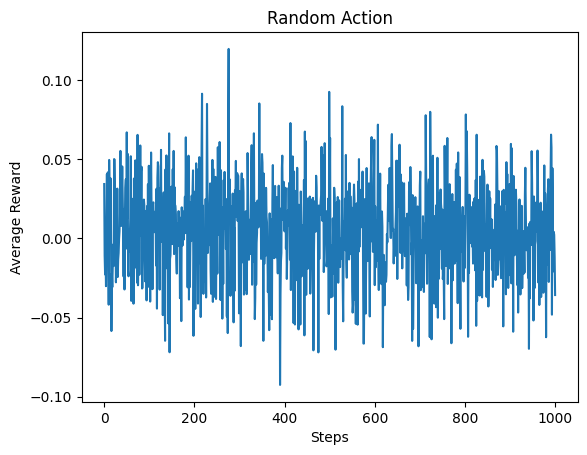

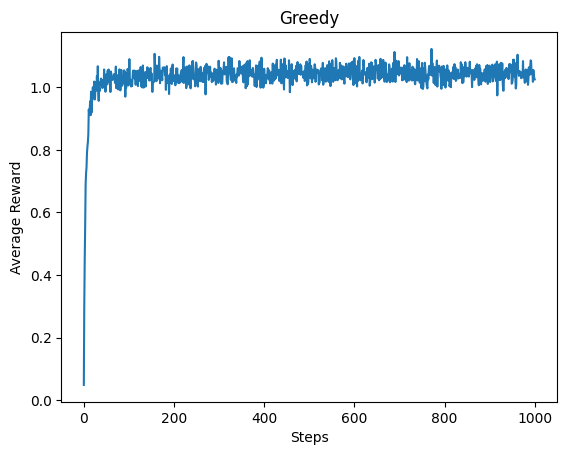

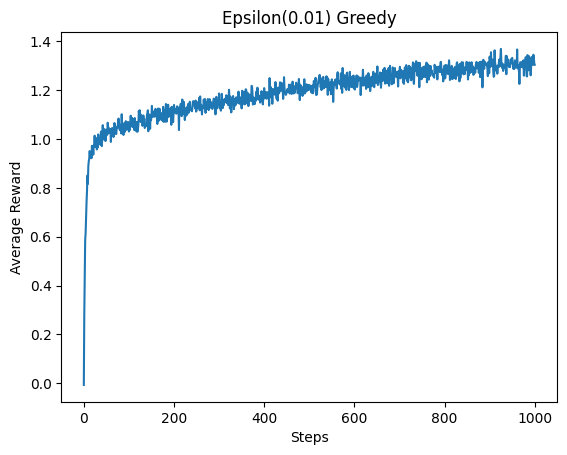

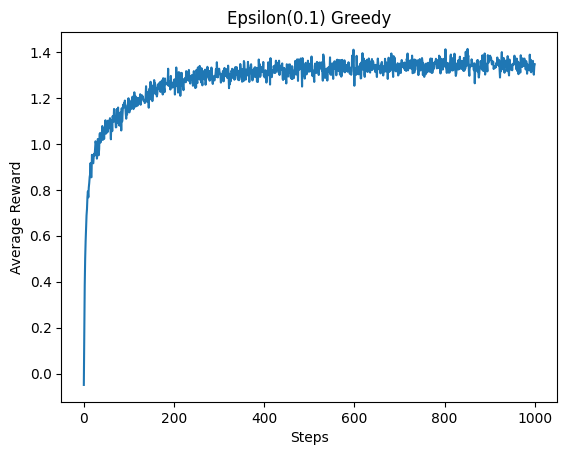

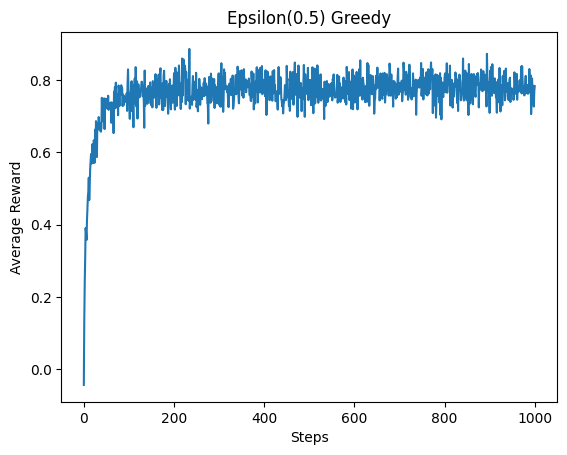

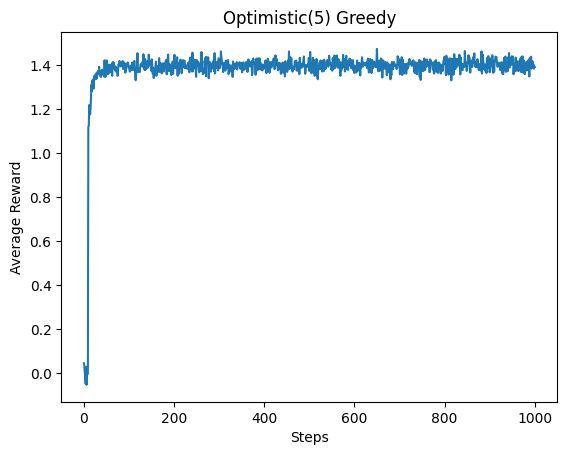

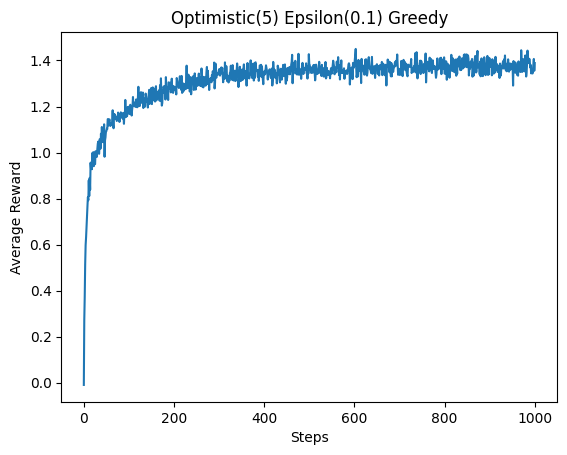

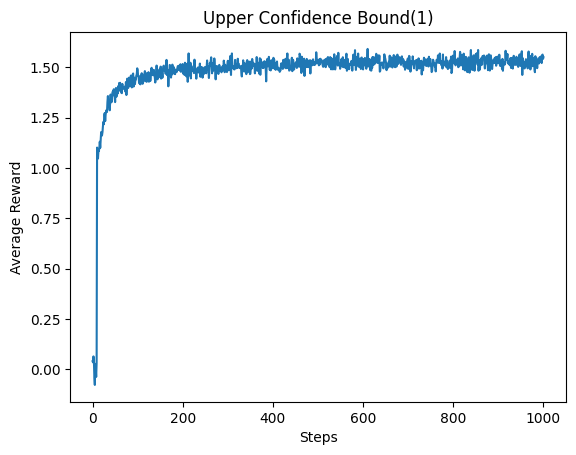

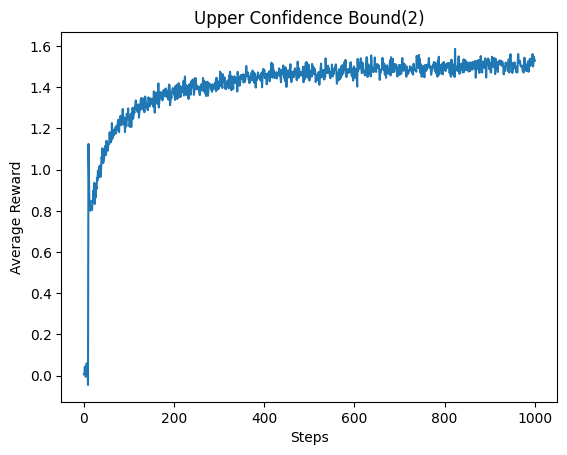

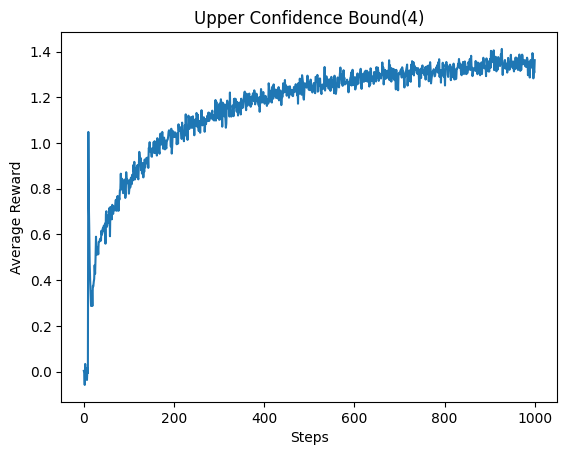

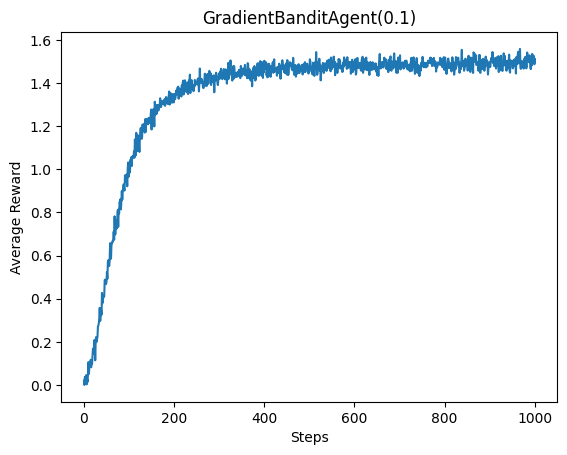

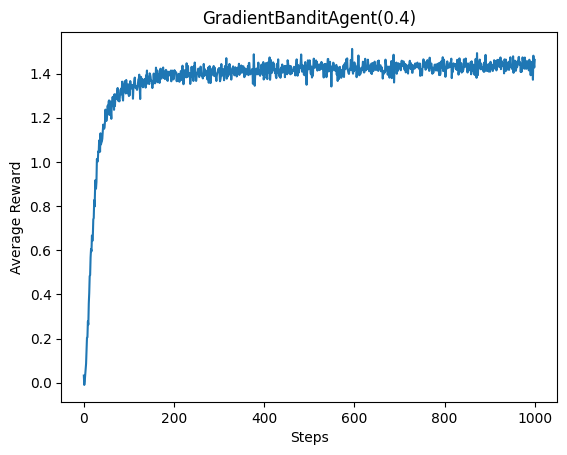

In [33]:
for name, stats in statistics.items():
    rewards_np = np.array(stats['rewards'])
    plt.plot(rewards_np.mean(axis=0))
    plt.title(name)
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.show()

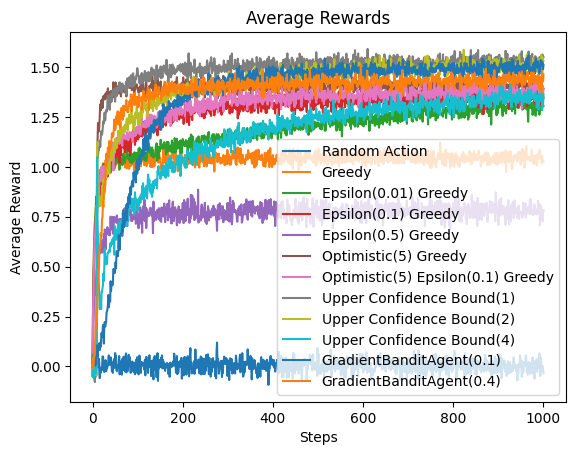

In [34]:
for name, stats in statistics.items():
    rewards_np = np.array(stats['rewards'])
    plt.plot(rewards_np.mean(axis=0), label=name)

plt.legend()
plt.title('Average Rewards')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


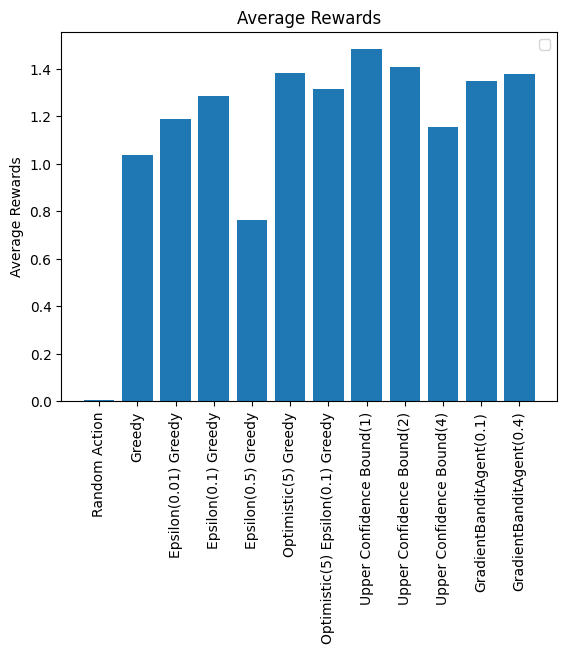

In [35]:
plt.bar(statistics.keys(), [np.array(stat['rewards']).mean() for stat in statistics.values()])
plt.xticks(rotation='vertical')
plt.legend()
plt.title('Average Rewards')
plt.ylabel('Average Rewards')
plt.show()

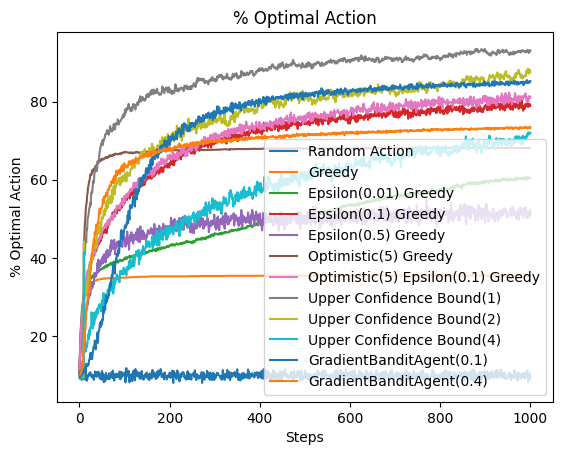

In [36]:
for name, stats in statistics.items():
    actions_performed = np.array(stats['actions_performed'])
    optimal_action = np.array(stats['optimal_action'])
    optimal_action_performed = np.zeros_like(actions_performed, dtype=np.int32)
    for i in range(len(optimal_action)):
        optimal_action_performed[i, :] = actions_performed[i, :] == optimal_action[i]
    plt.plot(optimal_action_performed.mean(axis=0)*100, label=name)

plt.legend()
plt.title('% Optimal Action')
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


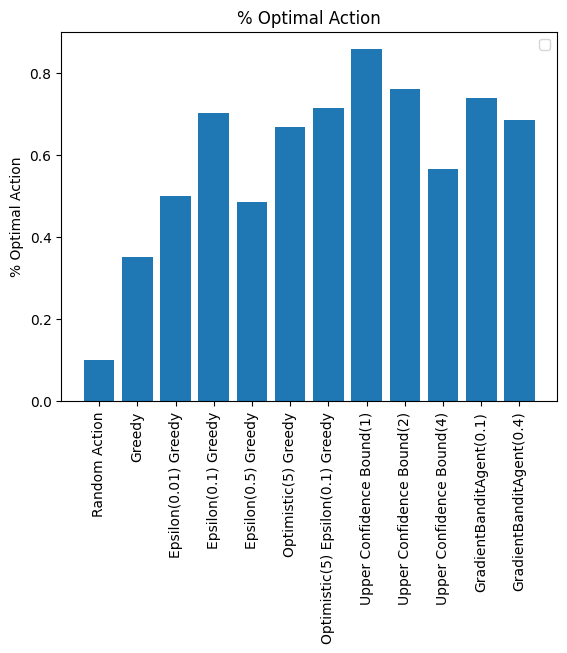

In [37]:
optimal_action_performed_all = [None] * len(statistics.keys())

for j, (name, stats) in enumerate(statistics.items()):
    actions_performed = np.array(stats['actions_performed'])
    optimal_action = np.array(stats['optimal_action'])
    optimal_action_performed = np.zeros_like(actions_performed, dtype=np.int32)
    for i in range(len(optimal_action)):
        optimal_action_performed[i, :] = actions_performed[i, :] == optimal_action[i]

    optimal_action_performed_all[j] = optimal_action_performed.mean()

plt.bar(statistics.keys(), optimal_action_performed_all)
plt.xticks(rotation='vertical')
plt.legend()
plt.title('% Optimal Action')
plt.ylabel('% Optimal Action')
plt.show()